In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.nn.utils.rnn as rnn_utils

import torch.nn as nn

from pytorch_metric_learning import losses as ml_losses 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import gc
import csv

import json
# from tqdm.auto import tqdm
from tqdm import tqdm
from datetime import datetime, date, time, timezone, timedelta
import pickle
import random

import math
from scipy.spatial import distance_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sn
from IPython.display import clear_output
from ipywidgets import Output
from IPython import display

In [2]:
#device = torch.cuda.device(2)
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
target_players = ['Anders ANTONSEN',
 'Anthony Sinisuka GINTING',
 'CHOU Tien Chen',
 'Jonatan CHRISTIE',
 'Kento MOMOTA',
 'NG Ka Long Angus',
 'Viktor AXELSEN']

In [4]:
def player2cat(player):
#     p2c = {'Anders ANTONSEN': 0, 'Anthony Sinisuka GINTING': 1, 'CHEN Long': 2,
#            'CHOU Tien Chen': 3, 'Jonatan CHRISTIE': 4, 'Kento MOMOTA': 5,
#            'NG Ka Long Angus': 6, 'Viktor AXELSEN': 7}
    p2c = {'Anders ANTONSEN': 0, 'Anthony Sinisuka GINTING': 1, 'CHOU Tien Chen': 2,
       'Jonatan CHRISTIE': 3, 'Kento MOMOTA': 4, 'NG Ka Long Angus': 5,
       'Viktor AXELSEN': 6}
    return p2c[player]

def cat2player(cat):
    c2p = {0:'ANTONSEN', 1:'GINTING', 2:'CHOU',
       3:'CHRISTIE', 4:'MOMOTA', 5:'NG',
       6:'AXELSEN'}
    return c2p[cat]

def generate_labels(rally_data):
    # predict player A and B
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]

    if playerA in target_players and playerB in target_players:
        return np.array([player2cat(playerA)]),  np.array([player2cat(playerB)])
    elif playerA not in target_players and playerB in target_players:
        return None,  np.array([player2cat(playerB)])
    elif playerA in target_players and playerB not in target_players:
        return np.array([player2cat(playerA)]),  None
    elif playerA in target_players and playerB in target_players:
        return None,  None

In [5]:
def type2cat(shot_type):
    t2c = {'發短球': 0, '長球': 1, '推球': 2, '殺球': 3, '擋小球': 4, '撲球': 5,
           '平球': 6, '放小球': 7, '挑球': 8, '點扣': 9, '勾球': 10, '過度切球': 11,
           '防守回抽': 12, '防守回挑': 13, '發長球': 14, '切球': 15, '後場抽平球': 16,
           '未知球種': 17, '小平球': 18}
    return t2c[shot_type]

def process_rally(rally_data):
    ## process config
    mean_x, std_x = 630., 160.
    mean_y, std_y = 470., 105.
    
    drop_cols = ['rally', 'ball_round', 'time', 'frame_num', 'db', 'flaw', 'lose_reason', 'win_reason', 'type', 'server', # no need
                 'hit_area', 'landing_area', 'player_location_area', 'opponent_location_area', # area dup with x/y
                 'name_A', 'name_B', 'getpoint_player', 'roundscore_A', 'roundscore_B', # rally-wise features, maybe use later
                 'landing_height', 'landing_x', 'landing_y'] # landing info is dup with hitting
    
    ## Get player name for checking
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]    
    
    ## process frame_num (time), get frame difference between last shot and this shot, 0 if serve ball 
    frame_diff = np.pad(rally_data['frame_num'].values[1:] - rally_data['frame_num'].values[:-1], (1, 0), mode='constant')
    rally_data['frame_diff'] = frame_diff
    
    ## NaN convert to binary
    rally_data['aroundhead'] = (rally_data['aroundhead'] == 1).astype(int)
    rally_data['backhand'] = (rally_data['backhand'] == 1).astype(int)
    
    ## Player A/B, convert to binary
    rally_data['player'] = (rally_data['player'] == 'A').astype(int)
    
    ## height convert to binary
    rally_data['hit_height'] = (rally_data['hit_height'] -1)
    rally_data['landing_height'] = (rally_data['landing_height'] -1)
    
    ## hit_x, hit_y fill with player location
    rally_data['hit_x'].values[0] = rally_data['player_location_x'].values[0]
    rally_data['hit_y'].values[0] = rally_data['player_location_y'].values[0]
    
    ## x/y standardization
    rally_data['hit_x'] = (rally_data['hit_x'] - mean_x)/std_x
    rally_data['hit_y'] = (rally_data['hit_y'] - mean_y)/std_y
    rally_data['landing_x'] = (rally_data['landing_x'] - mean_x)/std_x
    rally_data['landing_y'] = (rally_data['landing_y'] - mean_y)/std_y
    rally_data['player_location_x'] = (rally_data['player_location_x'] - mean_x)/std_x
    rally_data['player_location_y'] = (rally_data['player_location_y'] - mean_y)/std_y
    rally_data['opponent_location_x'] = (rally_data['opponent_location_x'] - mean_x)/std_x
    rally_data['opponent_location_y'] = (rally_data['opponent_location_y'] - mean_y)/std_y
    
    # type convert to category
    rally_data['type_code'] = [type2cat(t) for t in rally_data['type'].values]
    
    ## drop unneccesary columns
    rally_data.drop(columns=drop_cols, inplace=True)
    
    ## create a copy of the rally but with opposite player 
    inverse = rally_data.copy()
    inverse['player'] = (inverse['player']+1)%2
    
    if playerA in target_players and playerB in target_players:
        return rally_data.values, inverse.values
    elif playerA not in target_players and playerB in target_players:
        return None, inverse.values
    elif playerA in target_players and playerB not in target_players:
        return rally_data.values, None
    elif playerA in target_players and playerB in target_players:
        return None,  None


In [6]:
def collate_fn(data):
    seq, label = zip(*data)
    seq = list(seq)
    label = list(label)
    pairs = [(s, l) for s, l in zip(seq, label)]
    pairs.sort(key=lambda x: len(x[0]), reverse=True)
    seq = [s for s, l in pairs]
    label = [l for s, l in pairs]
    seq_length = [len(sq) for sq in seq]
    seq = rnn_utils.pad_sequence(seq, batch_first=True, padding_value=0)
    labels = torch.zeros(0, 1)
    for l in label:
        labels = torch.cat([labels, l], axis=0)
    return seq, seq_length, labels

In [7]:
data_path = 'aug_set_old.csv'

In [8]:
def check_nan(np_rally):
    if np_rally is None:
        return False
    else:
        return np.isnan(np.sum(np_rally))

In [9]:
data = pd.read_csv(data_path)

rids = set()
# drop flawed rallies, record label distribution
for rally in tqdm(data['rally'].unique()):
    a, b = process_rally(data.loc[data['rally']==rally].copy())
#     if (check_nan(a) or check_nan(b)) and (not data.loc[data['rally']==rally]['flaw'].any()):
#         print(rally)
#         for col in data.loc[data['rally']==rally].columns:
#             null_count = data.loc[data['rally']==rally][col].isnull().sum()
#             if null_count != 0:
#                 print(col, null_count)
#         input()
    if data.loc[data['rally']==rally]['flaw'].any() or len(data.loc[data['rally']==rally])<=2 or rally in [578, 596]:
        continue
    else:
        rids.add(rally)

100%|██████████| 2498/2498 [00:15<00:00, 160.52it/s]


In [10]:
def train_test_split(label2rids, test_ratio):
    test = random.sample(label2rids, k=round(len(label2rids)*test_ratio))
    train = [rid for rid in label2rids if rid not in test]
    return train, test

In [11]:
class PlayerClassificationDataset(Dataset):
    def __init__(self, data, rids, split):
        self.data = data
        self.rids = rids
        self.seqs = []
        self.labels = []
        
        pbar = tqdm(rids)
        pbar.set_description('Processing %s rally data'%split)
        tmp = [process_rally(self.data.loc[self.data['rally']==rally].copy()) for rally in pbar]
        for seq1, seq2 in tmp:
            if seq1 is not None:
                self.seqs.append(seq1)
            if seq2 is not None:
                self.seqs.append(seq2)
        
        pbar2 = tqdm(rids)
        pbar2.set_description('Generating %s labels'%split)
        tmp = [generate_labels(self.data.loc[self.data['rally']==rally].copy()) for rally in pbar2]
        for label1, label2 in tmp:
            if label1 is not None:
                self.labels.append(label1)
            if label2 is not None:
                self.labels.append(label2)        
        
        # checking data are clear, remove those with NaN
        self.nan_checking()
    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, index):
        return torch.Tensor(self.seqs[index]), torch.Tensor(self.labels[index]).unsqueeze(0)
    
    def nan_checking(self):
        bad_idxs = [idx for idx in range(len(self.seqs)) if check_nan(self.seqs[idx])]
        self.seqs = [seq for idx, seq in enumerate(self.seqs) if idx not in bad_idxs]
        self.labels = [label for idx, label in enumerate(self.labels) if idx not in bad_idxs]
        print("Removed %d rallies with NaN value!"%len(bad_idxs))

In [12]:
class SubsequenceClassificationDataset(Dataset):
    def __init__(self, data, rids, split, p, threshold):
        self.data = data
        self.rids = rids
        self.seqs = []
        self.labels = []
        self.p = p
        self.threshold = threshold
        
        pbar = tqdm(rids)
        pbar.set_description('Processing %s rally data'%split)
        tmp = [process_rally(self.data.loc[self.data['rally']==rally].copy()) for rally in pbar]
        for seq1, seq2 in tmp:
            if seq1 is not None:
                self.seqs.append(seq1)
            if seq2 is not None:
                self.seqs.append(seq2)
        
        pbar2 = tqdm(rids)
        pbar2.set_description('Generating %s labels'%split)
        tmp = [generate_labels(self.data.loc[self.data['rally']==rally].copy()) for rally in pbar2]
        for label1, label2 in tmp:
            if label1 is not None:
                self.labels.append(label1)
            if label2 is not None:
                self.labels.append(label2)        
        
        # checking data are clear, remove those with NaN
        self.nan_checking()
    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, index):
        ### if sequence length is longer than a threshold, random sample a sub-sequence with probability p
        dice = random.random()
        seq = self.seqs[index]
        if dice < self.p and len(seq) >= self.threshold:
            sub_len = random.randint(5, len(seq))
            start = random.randint(0, len(seq) - sub_len)
            sub_seq = seq[start:start+sub_len]
            return torch.Tensor(sub_seq), torch.Tensor(self.labels[index]).unsqueeze(0)
        else:
            return torch.Tensor(seq), torch.Tensor(self.labels[index]).unsqueeze(0)
    
    def nan_checking(self):
        bad_idxs = [idx for idx in range(len(self.seqs)) if check_nan(self.seqs[idx])]
        self.seqs = [seq for idx, seq in enumerate(self.seqs) if idx not in bad_idxs]
        self.labels = [label for idx, label in enumerate(self.labels) if idx not in bad_idxs]
        print("Removed %d rallies with NaN value!"%len(bad_idxs))

In [14]:
def triplet_collate(data):
    anchor, positive, negative, anchor_label, positive_label, negative_label = zip(*data)
    anchor, positive, negative = list(anchor), list(positive), list(negative)
    anchor_label, positive_label, negative_label = list(anchor_label), list(positive_label), list(negative_label)

    anchor_label = torch.tensor(anchor_label)
    anchor_len = [len(a) for a in anchor]
    anchor = rnn_utils.pad_sequence(anchor, batch_first=True, padding_value=0)


    positive_label = torch.tensor(positive_label)
    positive_len = [len(p) for p in positive]
    positive = rnn_utils.pad_sequence(positive, batch_first=True, padding_value=0)

    negative_label = torch.tensor(negative_label)
    negative_len = [len(n) for n in negative]
    negative = rnn_utils.pad_sequence(negative, batch_first=True, padding_value=0)

    return anchor, positive, negative, anchor_len, positive_len, negative_len, anchor_label

In [13]:
class TripletSamplingDataset(Dataset):
    def __init__(self, dataset, num_classes, weights=None):
        self.num_classes = num_classes
        self.dataset = dataset
        self.num_seqs = len(self.dataset)
        if weights is not None:
            self.weights = weights
        else:
            # use uniform if weights not provided
            self.weights = np.array([1 for i in range(self.num_classes)])
        
        self.label2idxs = {i: [] for i in range(num_classes)}
        self.build_label2idxs()
        
        self.dist_mtrx = np.random.rand(self.num_seqs, self.num_seqs)
    
    def __len__(self):
        return self.num_seqs
    
    def __getitem__(self, index):
        anchor, anchor_label = self.dataset[index]
        positive, positive_label = self.dataset[self.sample_positive(index, anchor_label.long().item())]
        negative, negative_label = self.dataset[self.distance_weighted_negative_sample(index, anchor_label.long().item())]
        return anchor, positive, negative, anchor_label, positive_label, negative_label
    
    def build_label2idxs(self):
        for idx, (seq, label) in enumerate(self.dataset):
            label = label.long().item()
            self.label2idxs[label].append(idx)
    
    def sample_positive(self, anchor_index, label):
        pool = self.label2idxs[label].copy()
        pool.remove(anchor_index)
        return random.choice(pool)
    
    def sample_negative(self, anchor_index, label):
        # First sample the negative class according to given class weight
        # Then perform distance weighted sampling on the target class's samples
        class_pool = np.array([i for i in range(self.num_classes) if i!=label])
        weights = self.weights[class_pool]
        sample_class = np.random.choice(class_pool, size=1, p=weights/weights.sum())[0].astype(int)
        pool = self.label2idxs[sample_class].copy()
        # do sorting to prevent potential problem, might cause efficiency problem though
        pool.sort()
        # pool is a list of idx, so we now get distance of these idx to anchor
        dist = self.dist_mtrx[anchor_index][pool]
        # uniformly sample a distance in [dist.min(), dist.max()]
        sampled_dist = np.random.uniform(dist.min(), dist.max())
        # get the index which have closest distance to the sampled distance
        closest_idx = np.argmin(np.power(dist - sampled_dist, 2))
        return pool[closest_idx]
    
    def distance_weighted_negative_sample(self, anchor_index, label):
        class_pool = np.array([i for i in range(self.num_classes) if i!=label])
        index_pool = []
        for label in class_pool:
            index_pool.extend(self.label2idxs[label].copy())
        index_pool.sort()
        dist_list = self.dist_mtrx[anchor_index][index_pool]
        dist_list = [dist if dist < 1e5 else 1e5 for dist in dist_list]
        dist_list = [dist if dist != 0 else 1e-5 for dist in dist_list]
        dist_list = np.array(dist_list)
        dist_list = 1 / dist_list
        sample_idx = np.random.choice(index_pool, size=1, p=dist_list/dist_list.sum())[0].astype(int)
        return sample_idx
    
    def update_distance(self, embeddings):
        self.dist_mtrx = torch.cdist(embeddings, embeddings, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary').cpu().numpy()

In [15]:
class MLP(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(in_dim, mid_dim)
        self.linear2 = nn.Linear(mid_dim, out_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [16]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, out_dim, GRU_layers):
        super(SimpleNet, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.GRU_layers = GRU_layers
        
        self.type_embedding = nn.Embedding(19, self.embed_dim)
        self.proj = nn.Linear(self.input_dim - 1, self.hidden_dim - self.embed_dim)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.GRU = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.GRU_layers, bias=True, batch_first=True, bidirectional=True)
        #self.output = MLP(self.hidden_dim, self.hidden_dim//16, self.out_dim)
        self.fc2 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.out_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, seq, seq_length):
        feats = seq[:, :, :-1]
        code = seq[:, :, -1].long()
        embed = self.type_embedding(code)
        feats_proj = self.proj(feats)
        x = torch.cat([feats_proj, embed], axis=-1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        x = rnn_utils.pack_padded_sequence(x, seq_length, batch_first=True, enforce_sorted=False)
        output, h_n = self.GRU(x)
        # output: [batch_size , seq_len, hidden_dim], h_n: [num_layers, batch_size, hidden_dim]
        #x = h_n.permute(1, 0, 2)[:, -1, :]
        out_pad, out_len = rnn_utils.pad_packed_sequence(output, batch_first=True)
        x = out_pad[torch.arange(out_len.shape[0]), out_len-1, :]
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.relu(x)
        y = self.output(x)
        x = self.sigmoid(x)
        return x, y

In [17]:
class CNNRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, out_dim, GRU_layers):
        super(CNNRNN, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.GRU_layers = GRU_layers
        
        self.type_embedding = nn.Embedding(19, self.embed_dim)
        self.proj = nn.Linear(self.input_dim - 1, self.hidden_dim - self.embed_dim)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.conv1 = nn.Conv1d(self.hidden_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1)
        self.GRU = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.GRU_layers, bias=True, batch_first=True, bidirectional=True)
        #self.output = MLP(self.hidden_dim, self.hidden_dim//16, self.out_dim)
        self.fc2 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.out_dim) # in_dim is hidden_dim
        self.relu = nn.ReLU()
        
    def forward(self, seq, seq_length):
        feats = seq[:, :, :-1]
        code = seq[:, :, -1].long()
        embed = self.type_embedding(code)
        feats_proj = self.proj(feats)
        x = torch.cat([feats_proj, embed], axis=-1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        
#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = x.permute(0, 2, 1)
#         x = self.relu(x)
        
        x = rnn_utils.pack_padded_sequence(x, seq_length, batch_first=True, enforce_sorted=False)
        output, h_n = self.GRU(x)
        # output: [batch_size , seq_len, hidden_dim], h_n: [num_layers, batch_size, hidden_dim]
        #x = h_n.permute(1, 0, 2)[:, -1, :]
        out_pad, out_len = rnn_utils.pad_packed_sequence(output, batch_first=True)
        x = out_pad[torch.arange(out_len.shape[0]), out_len-1, :]
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        y = self.output(x)
        return x, y

In [18]:
class EmbeddingDistanceLoss(nn.Module):
    def __init__(self, num_classes, weight=None):
        super(EmbeddingDistanceLoss, self).__init__()
        self.num_classes = num_classes
        self.weight = weight
        
    def forward(self, output, label, embeddings):
        batch_size = output.shape[0]
        dist_mtrx = torch.cdist(output, embeddings, p=2)
        dist_mtrx = dist_mtrx*self.weight

        return (torch.mean(torch.tensor([-0.1/self.num_classes]).cuda()*dist_mtrx) + torch.mean(self.num_classes*dist_mtrx[:, label]))/batch_size

In [19]:
def update_class_embedding(output, label, class_embedding, alpha):
    tmp_embedding = torch.clone(class_embedding)
    tmp_embedding[label, :] = class_embedding[label, :]*(1-alpha) + output*alpha
    class_embedding = tmp_embedding

In [20]:
def metrices(preds, labels, num_classes):
    acc = []
    precision = []
    recall = []
    f1 = []
    count = [] 
    
    TP_all = 0
    FP_all = 0
    TN_all = 0
    FN_all = 0
    for target in range(num_classes):
        cnt = 0
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(preds)):
            if labels[i]==target:
                cnt += 1
            if preds[i]==target and labels[i]==target:
                TP += 1
                TP_all += 1
            elif preds[i]==target and labels[i]!=target:
                FP += 1
                FP_all += 1
            elif preds[i]!=target and labels[i]!=target:
                TN += 1
                TN_all += 1
            elif preds[i]!=target and labels[i]==target:
                FN += 1
                FN_all += 1
        acc.append((TP+TN)/(TP+FP+TN+FN+1e-10))
        precision.append((TP)/(TP+FP+1e-10))
        recall.append(TP/(TP+FN+1e-10))
        f1.append(2*(precision[target]*recall[target])/(precision[target]+recall[target]+1e-10))
        count.append(cnt)
            
    num_exist_class = len([1 for c in count if c!=0]) + 1e-10
    return sum(acc)/num_exist_class, sum(precision)/num_exist_class, sum(recall)/num_exist_class, sum(f1)/num_exist_class, None

def confusion_matrix(preds, labels, num_classes, ax):
    conf = np.zeros((num_classes, num_classes))
    for i in range(len(preds)):
        conf[preds[i]][labels[i]] += 1

    norm_vec = np.sum(conf, axis=0)
    conf = np.around(conf/norm_vec, decimals=2)
    df_cm = pd.DataFrame(conf, [cat2player(i) for i in range(num_classes)], [cat2player(i) for i in range(num_classes)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap='GnBu', fmt='g', ax=ax)
    b, t = ax.get_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    ax.set_title("Confusion Matrix of Player Classification")
    ax.set_ylim(b, t) # update the ylim(bottom, top) values
    ax.xaxis.set_tick_params(rotation=45)
    ax.yaxis.set_tick_params(rotation=45)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Prediction')
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.title.set_fontsize(16)


def validation(net, class_embedding, testloader, num_classes, epoch, ax, conf=False):
    labels = []
    preds = []
    for idx, (seq, seq_length, label) in enumerate(testloader):
        # seq: [batch x padded length x feat dim]
        # label [batch x 2]
        sigmoid = nn.Sigmoid()
        seq, label = torch.Tensor(seq).cuda(), torch.Tensor(label).long().cuda()
        output,_ = net(seq, seq_length)
        
        pred = torch.argmin(torch.cdist(output, class_embedding, p=2), dim=-1)
        #pred = torch.argmax(output, dim=-1)
        
        labels.append(label.cpu().item())
        preds.append(pred.detach().cpu().item())

    acc, prec, rec, f1, ACC = metrices(preds, labels, num_classes)
    if conf:
        confusion_matrix(preds, labels, num_classes, ax)
    #print("Epoch No.%d\tAcc: %3f, F1: %3f"%(epoch, rec, f1))
    return rec, f1

In [21]:
def moving_average(lst, wind_size):
    lst = [sum(lst[i:i+wind_size])/wind_size for i in range(0, len(lst)-wind_size)]
    return lst

def plots(losses, accs, f1s, wind_size, ax1):
    ax2 = ax1.twinx()
    
    y1 = moving_average(losses, wind_size)
    x1 = [i for i in range(len(y1))]
    
    y2 = accs
    x2_step = round(len(x1)/len(y2))
    x2 = [i*x2_step for i in range(1, len(y2)+1)]
    
    y3 = f1s

    curve1, = ax1.plot(x1, y1, label="Training loss", color='r')
    curve2, = ax2.plot(x2, y2, label="Test accuracy", color='b')
    curve3, = ax2.plot(x2, y3, label="Test F1", color='g')
    
    curves = [curve1, curve2, curve3]
    ax1.legend(curves, [curve.get_label() for curve in curves], loc='center right')
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Acc/F1")
    
    ax1.set_title("Learning Curve")
    
    for item in ([ax1.xaxis.label, ax1.yaxis.label, ax2.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels() +  ax2.get_yticklabels()):
        item.set_fontsize(12)
    ax1.title.set_fontsize(16)
    

In [22]:
# def generate_class_embedding(num_classes, hidden_dim, model, pc_dataset):
#     class_embedding = [torch.zeros(0, hidden_dim*2).cuda() for i in range(num_classes)]
#     for seq, label in pc_dataset:
#         label = label.long().item()
#         seq = seq.cuda()
#         output = model(seq.unsqueeze(0), [seq.shape[-2]])

#         class_embedding[label] = torch.cat([class_embedding[label], output], axis=0)

#     tmp = torch.zeros(0, hidden_dim*2).cuda()
#     for i in range(num_classes):
#         tmp = torch.cat([tmp, torch.mean(class_embedding[i], dim=0, keepdim=True)], axis=0)

#     class_embedding = tmp
#     return class_embedding

def generate_class_embedding(num_classes, hidden_dim, model, pc_loader):
    with torch.no_grad():
        model.eval()
        class_embedding = torch.zeros(num_classes, hidden_dim).cuda()
        class_count = torch.zeros(num_classes).cuda()

        for seq, seq_length, labels in pc_loader:
            seq = seq.cuda()

            # labels: [batch_size]
            labels = labels.squeeze(1).long().cuda()
            # output: [batch_size x hidden_dim*2]
            output,_ = model(seq, seq_length)

            # add embeddings to corresponding class_embedding
            #scatter [num_classes x batch_size]
            scatter = torch.zeros(num_classes, labels.shape[0]).cuda()
            scatter[labels, torch.tensor([i for i in range(labels.shape[0])])] = 1

            # add class count
            class_count += scatter.sum(axis=1)

            # scatter*output [num_classes x hidden_dim*2]
            class_embedding += torch.matmul(scatter, output)

        class_embedding /= class_count.unsqueeze(1).expand(num_classes, hidden_dim)
    
    return class_embedding

In [23]:
def generate_all_embedding(num_classes, hidden_dim, model, pc_loader):
    with torch.no_grad():
        model.eval()
        embeddings = torch.zeros(0, hidden_dim).cuda()
        classes = torch.zeros(0).long().cuda()

        for seq, seq_length, labels in pc_loader:
            seq = seq.cuda()

            # labels: [batch_size]
            labels = labels.squeeze(1).long().cuda()
            # output: [batch_size x hidden_dim*2]
            output,_ = model(seq, seq_length)

            embeddings = torch.cat([embeddings, output], axis=0)
            classes = torch.cat([classes, labels], axis=0)
            
    return embeddings, classes.cpu().numpy()

def tsne_viz(embeddings, labels, ax, set_):
    reduced = TSNE(n_components=2, perplexity=30.0).fit_transform(embeddings)
    
    scatter_x = reduced[:, 0]
    scatter_y = reduced[:, 1]
    group = labels
    cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'cyan', 4: 'magenta', 5: 'yellow', 6: 'black', 7: 'lightgray'}

    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = cat2player(g), s = 2)
    ax.legend()
    ax.set_title('Visualization of Embeddings on %s Set'%set_)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
def tsne_viz_train_test(train_embeddings, train_labels, test_embeddings, test_labels, class_embedding, ax, mode):
    train_range = train_embeddings.shape[0]
    test_range = train_range + test_embeddings.shape[0]
    embeddings = np.concatenate((train_embeddings, test_embeddings, class_embedding), axis=0)
    labels = np.concatenate((train_labels, test_labels, np.array([i for i in range(class_embedding.shape[0])])), axis=0)

    if mode=='tsne':
        reduced = TSNE(n_components=2, perplexity=30.0).fit_transform(embeddings)
    elif mode=='pca':
        reduced = PCA(n_components=2, svd_solver='full').fit_transform(embeddings)
    else:
        raise NotImplemented('Only t-SNE and PCA visualizations are supported currenly')
    
    train_x = reduced[:train_range, 0]
    train_y = reduced[:train_range, 1]
    train_group = labels[:train_range]
    
    test_x = reduced[train_range:test_range, 0]
    test_y = reduced[train_range:test_range, 1]
    test_group = labels[train_range:test_range]
    
    class_x = reduced[test_range:, 0]
    class_y = reduced[test_range:, 1]
    class_group = labels[test_range:]

    
    cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'cyan', 4: 'magenta', 5: 'yellow', 6: 'gray'}

    for g in np.unique(train_group):
        ix = np.where(train_group == g)
        ax.scatter(train_x[ix], train_y[ix], c = cdict[g], s = 4, alpha=0.05)
    
    for g in np.unique(test_group):
        ix = np.where(test_group == g)
        ax.scatter(test_x[ix], test_y[ix], c = cdict[g], label = cat2player(g), s = 10, alpha=0.8)
    
    for g in np.unique(class_group):
        ix = np.where(class_group == g)
        ax.scatter(class_x[ix], class_y[ix], c = cdict[g], s = 200, marker = '*', edgecolors='black')
    
    ax.legend()
    if mode == 'tsne':
        ax.set_title('Visualization of Embeddings (t-SNE)')
    else:
        ax.set_title('Visualization of Embeddings (PCA)')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

In [24]:
train, test = train_test_split(rids, 0.2)

pc_dataset = PlayerClassificationDataset(data, train, 'train')
#pc_dataset = SubsequenceClassificationDataset(data, train, 'train', p=0.5, threshold=5)
weights = np.array([1., 1., 1.5, 1.5, 0.5, 1, 1])
train_dataset = TripletSamplingDataset(pc_dataset, num_classes=7, weights=weights)
test_dataset = PlayerClassificationDataset(data, test, 'test')

Processing test rally data:   0%|          | 0/402 [00:00<?, ?it/s]

Removed 2 rallies with NaN value!


Generating test labels: 100%|██████████| 402/402 [00:00<00:00, 2314.64it/s]

Removed 0 rallies with NaN value!


In [25]:
len(pc_dataset.seqs), len(pc_dataset.labels), len(test_dataset.seqs), len(test_dataset.labels)

(2927, 2927, 721, 721)

In [33]:
pc_loader = DataLoader(pc_dataset, batch_size=64, shuffle=True, num_workers=12, collate_fn=collate_fn)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12, collate_fn=triplet_collate)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=12, collate_fn=collate_fn)

In [27]:
EPOCHS = 500
num_classes = 7
hidden_dim = 2048
lr = 1e-4

In [28]:
class TripletLoss_SoftMargin(nn.Module):
    def __init__(self):
        super(TripletLoss_SoftMargin, self).__init__()
        self.Loss = nn.SoftMarginLoss()

    def forward(self, anchor, pos, neg):
        num_samples = anchor.shape[0]
        y = torch.ones((num_samples, 1)).view(-1)
        if anchor.is_cuda: y = y.cuda()
        ap_dist = torch.norm(anchor - pos, 2, dim = 1).view(-1)
        an_dist = torch.norm(anchor - neg, 2, dim = 1).view(-1)
        loss = self.Loss(an_dist - ap_dist, y)
       
        return loss


In [29]:
class MarginBasedLoss(nn.Module):
    def __init__(self):
        super(MarginBasedLoss, self).__init__()
        self.a = 0.2
        self.b = 1.2
    def forward(self, anchor, pos, neg):
        pos_dist = torch.norm(anchor - pos, 2, dim = 1).view(-1)
        neg_dist = torch.norm(anchor - neg, 2, dim = 1).view(-1)
        pos_margin = self.a + (pos_dist - self.b)
        pos_margin[pos_margin < 0] = 0
        pos_loss = torch.sum(pos_margin)
        
        neg_margin = self.a - neg_dist + self.b
        neg_margin[neg_margin < 0] = 0
        neg_loss = torch.sum(neg_margin)
        loss = pos_loss + neg_loss 
        return loss

In [30]:
#net = SimpleNet(12, 128, hidden_dim, num_classes, 2).cuda()
net = CNNRNN(12, 128, hidden_dim, num_classes, 2).cuda()
class_embedding = torch.randn(num_classes, hidden_dim).cuda()
class_embedding.require_grad = False

#optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)

triplet_loss = nn.TripletMarginLoss(margin=0.5, p=2).cuda()
# triplet_loss = TripletLoss_SoftMargin().cuda()
# margin_loss = MarginBasedLoss()
ce_loss = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)

In [31]:
train_embeddings, _ = generate_all_embedding(num_classes, hidden_dim, net, pc_loader)
class_embedding = generate_class_embedding(num_classes, hidden_dim, net, pc_loader)

trainloader.dataset.update_distance(train_embeddings)

torch.Size([64, 60, 12])
11
1920
torch.Size([64, 31, 12])
11
1920
torch.Size([64, 36, 12])
11
1920
torch.Size([64, 37, 12])
11
1920
torch.Size([64, 46, 12])
11
1920
torch.Size([64, 40, 12])
11
1920
torch.Size([64, 34, 12])
11
1920
torch.Size([64, 30, 12])
11
1920
torch.Size([64, 28, 12])
11
1920
torch.Size([64, 34, 12])
11
1920
torch.Size([64, 48, 12])
11
1920
torch.Size([64, 32, 12])
11
1920
torch.Size([64, 30, 12])
11
1920
torch.Size([64, 39, 12])
11
1920
torch.Size([64, 34, 12])
11
1920
torch.Size([64, 34, 12])
11
1920
torch.Size([64, 43, 12])
11
1920
torch.Size([64, 65, 12])
11
1920
torch.Size([64, 41, 12])
11
1920
torch.Size([64, 39, 12])
11
1920
torch.Size([64, 44, 12])
11
1920
torch.Size([64, 43, 12])
11
1920
torch.Size([64, 34, 12])
11
1920
torch.Size([64, 34, 12])
11
1920
torch.Size([64, 37, 12])
11
1920
torch.Size([64, 60, 12])
11
1920
torch.Size([64, 43, 12])
11
1920
torch.Size([64, 40, 12])
11
1920
torch.Size([64, 65, 12])
11
1920
torch.Size([64, 43, 12])
11
1920
torch.Size

KeyboardInterrupt: 

Output()

  5%|▍         | 24/500 [28:20<9:22:18, 70.88s/it]

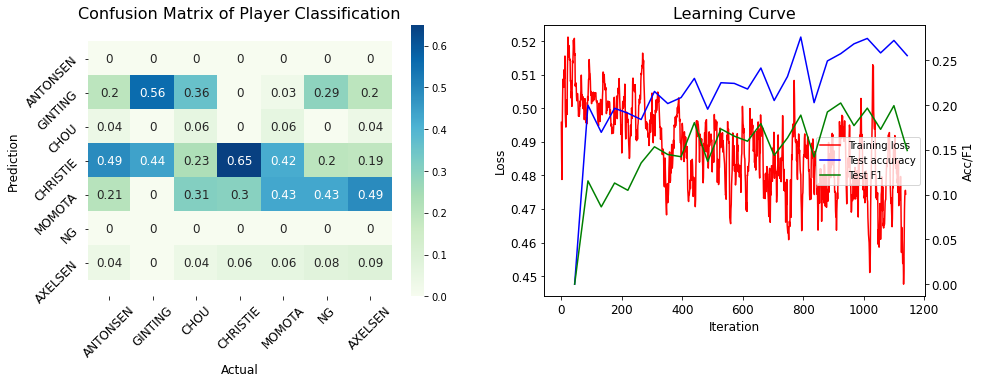

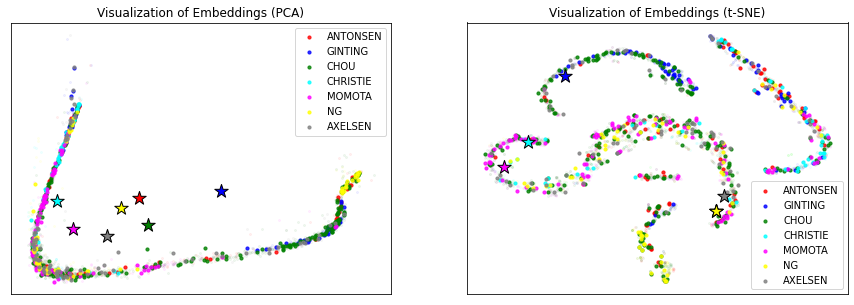

 10%|▉         | 49/500 [58:29<8:51:46, 70.75s/it] 

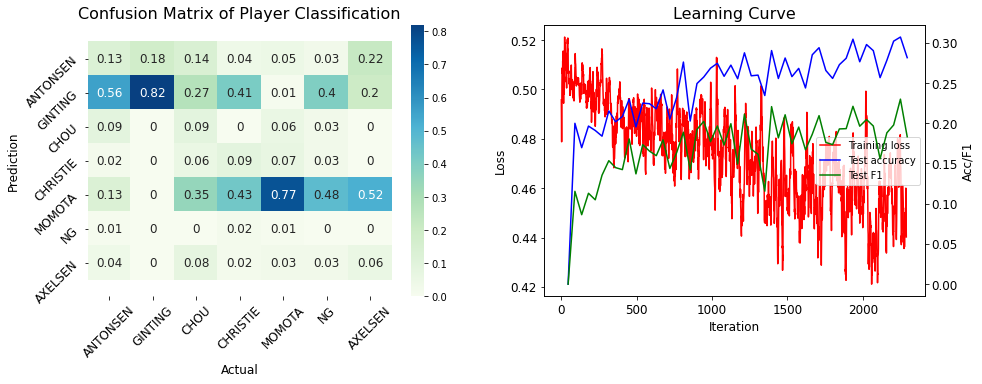

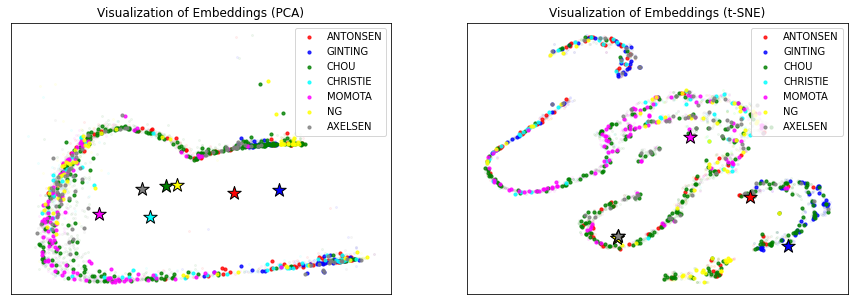

 15%|█▍        | 74/500 [1:28:33<8:24:57, 71.12s/it] 

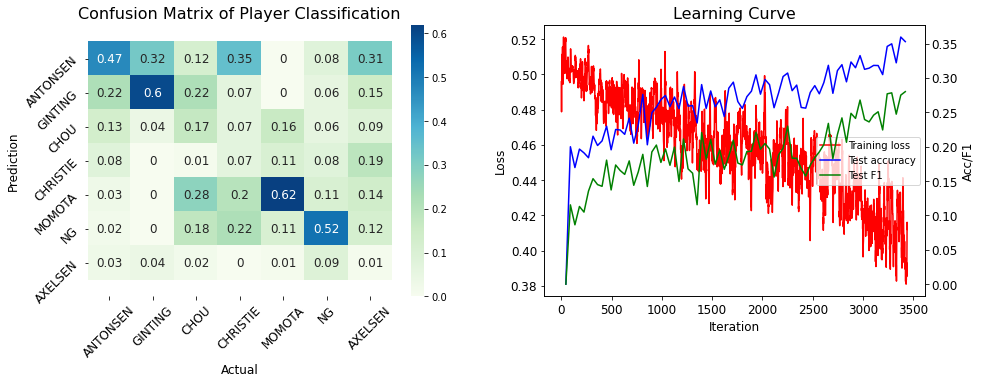

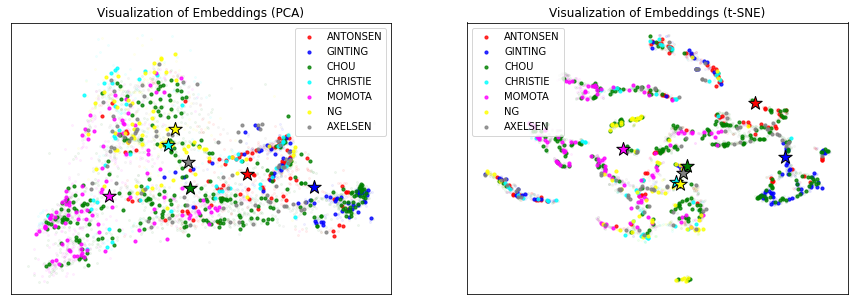

 20%|█▉        | 99/500 [1:58:39<7:50:46, 70.44s/it]

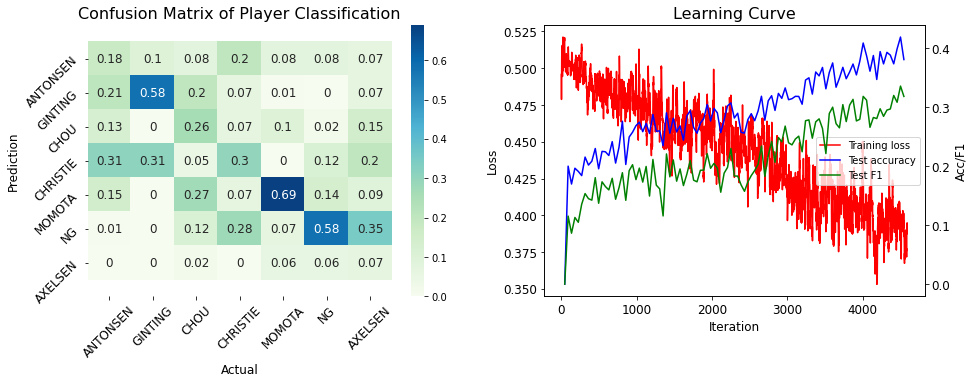

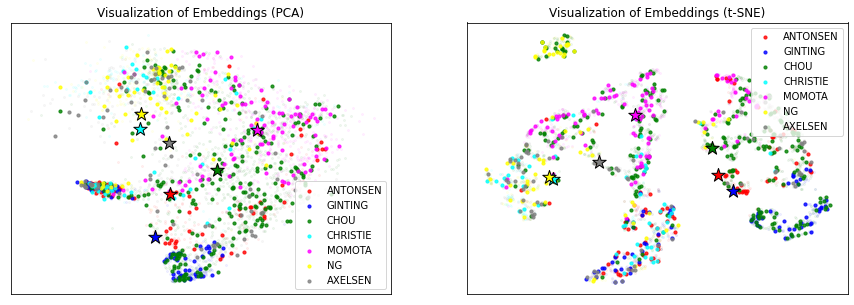

 25%|██▍       | 124/500 [2:27:59<7:09:35, 68.55s/it]

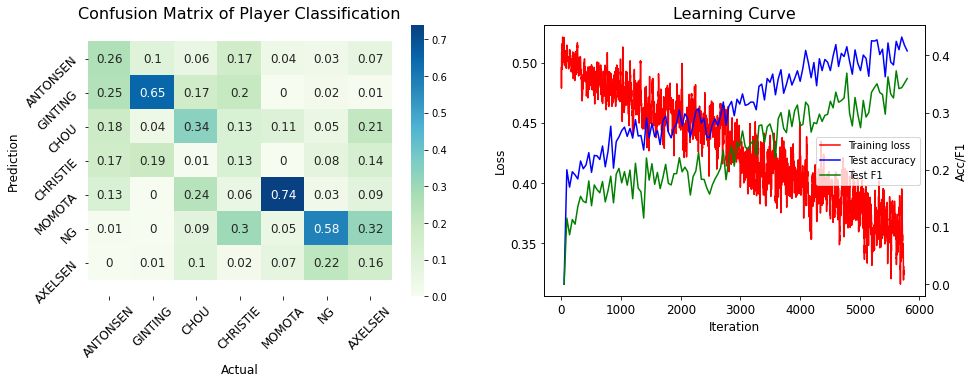

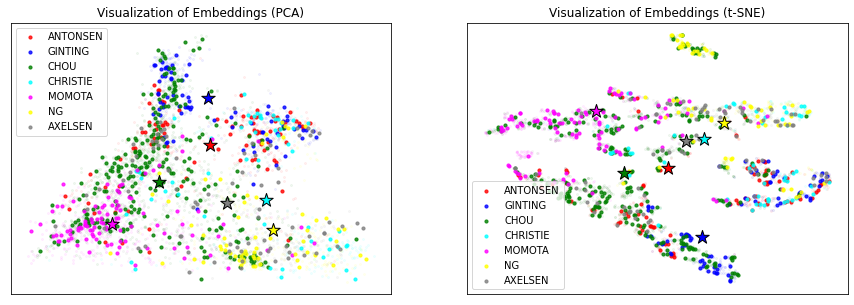

 30%|██▉       | 149/500 [2:57:19<6:43:19, 68.94s/it]

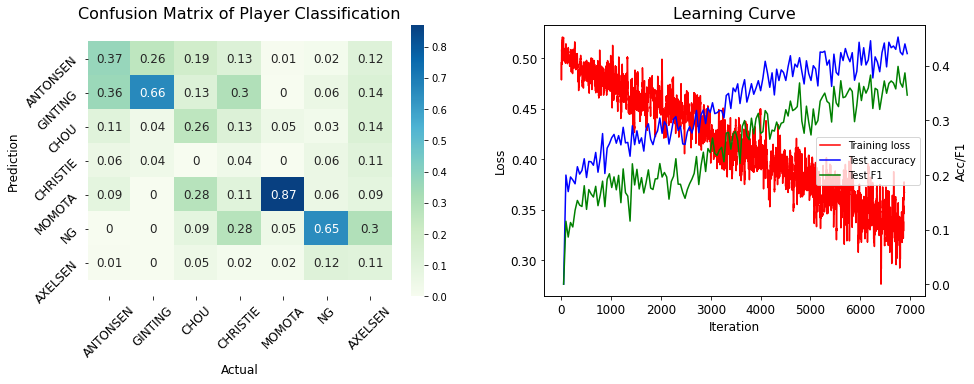

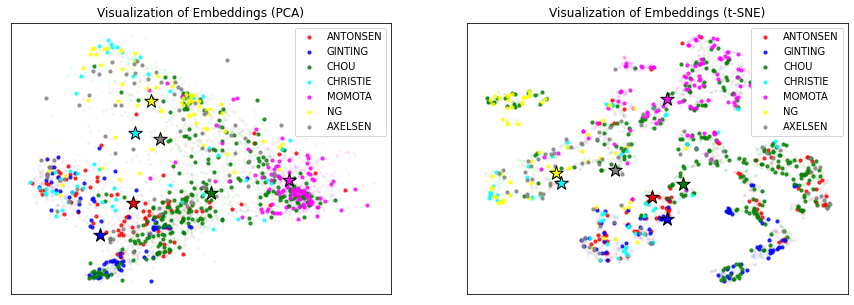

 35%|███▍      | 174/500 [3:26:36<6:12:27, 68.55s/it]

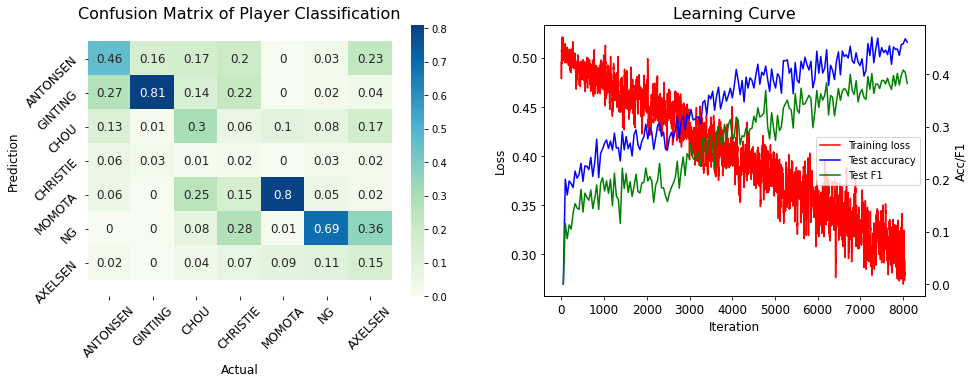

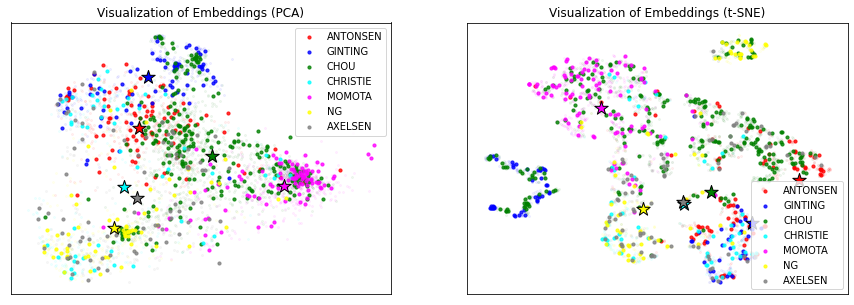

 40%|███▉      | 199/500 [3:55:54<5:44:36, 68.69s/it]

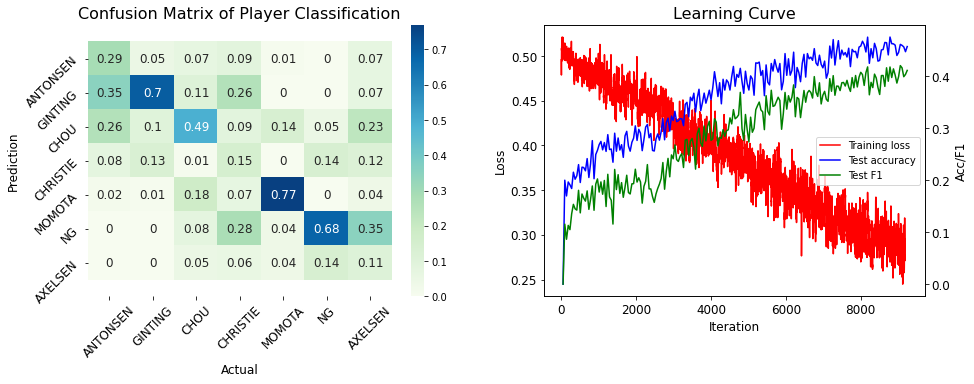

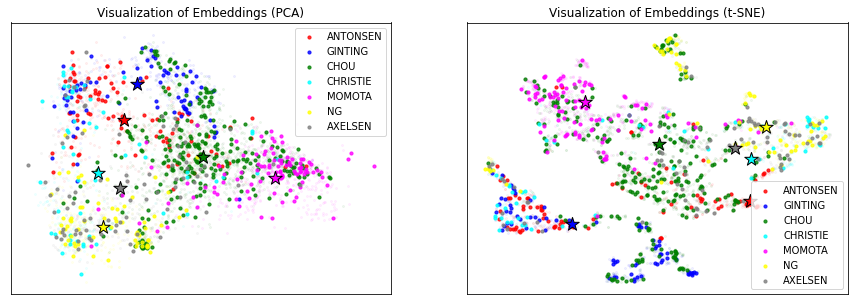

 45%|████▍     | 224/500 [4:25:09<5:15:21, 68.56s/it]

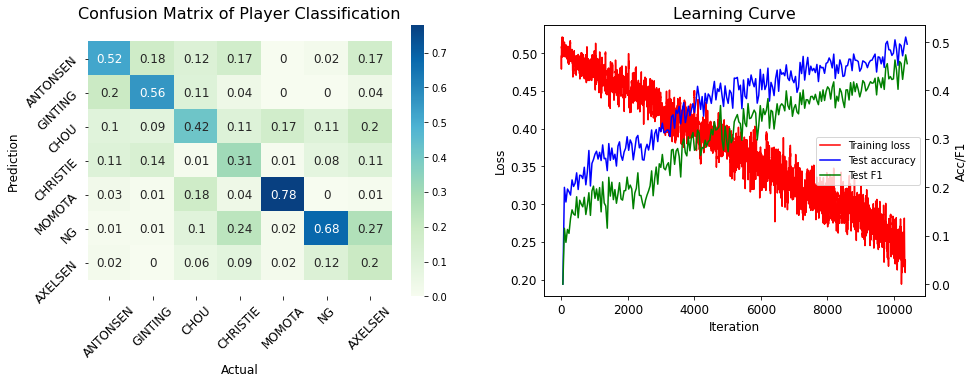

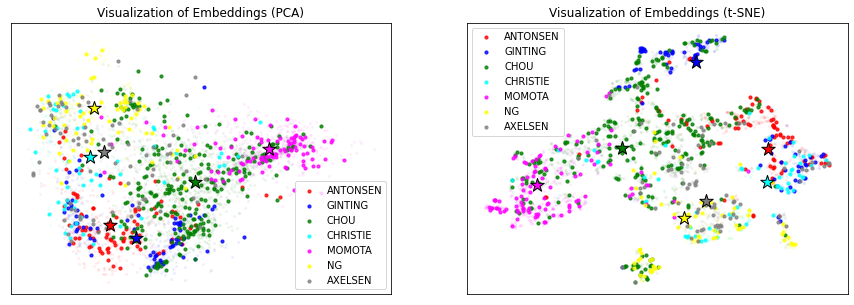

 50%|████▉     | 249/500 [4:54:33<4:47:31, 68.73s/it]

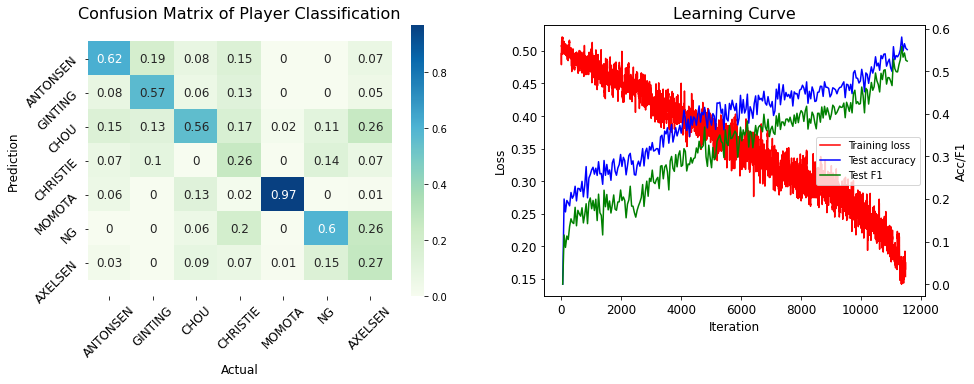

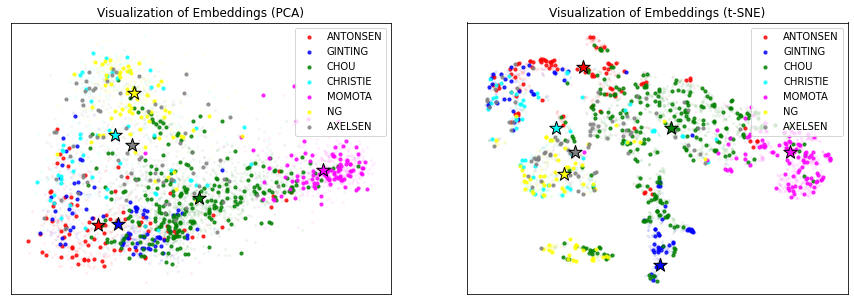

 55%|█████▍    | 274/500 [5:23:55<4:18:55, 68.74s/it]

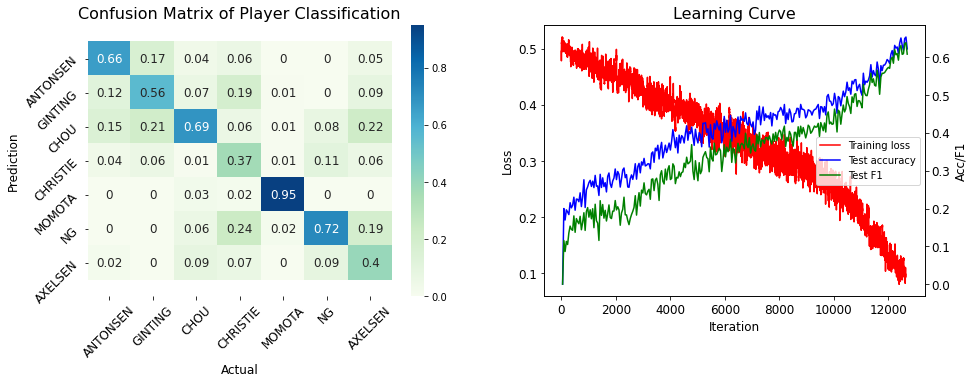

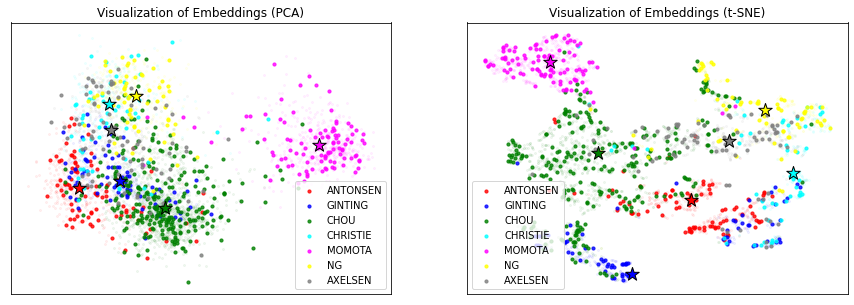

 60%|█████▉    | 299/500 [5:53:15<3:49:28, 68.50s/it]

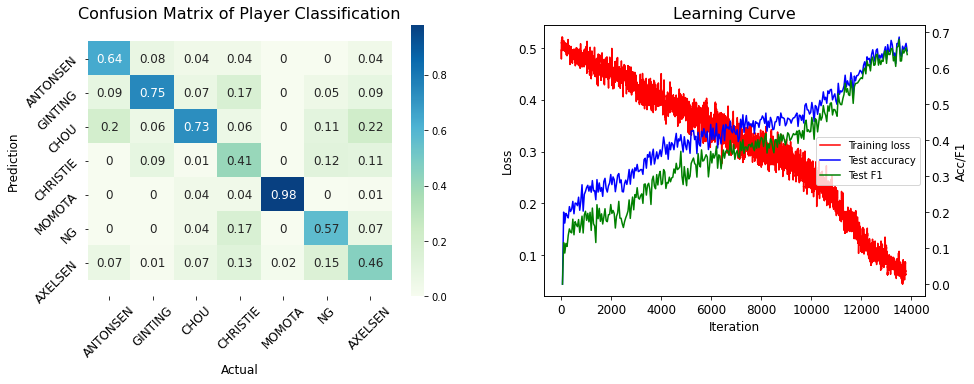

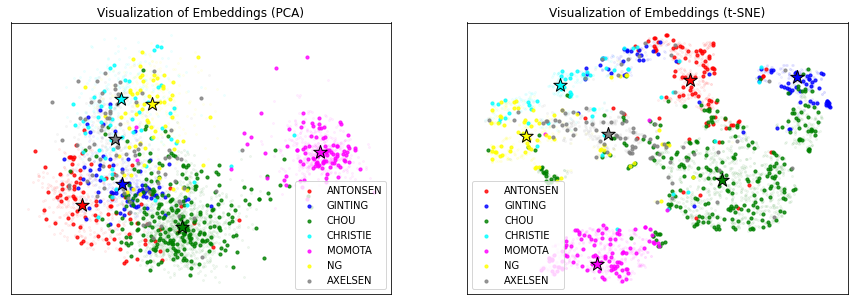

 65%|██████▍   | 324/500 [6:22:30<3:19:51, 68.14s/it]

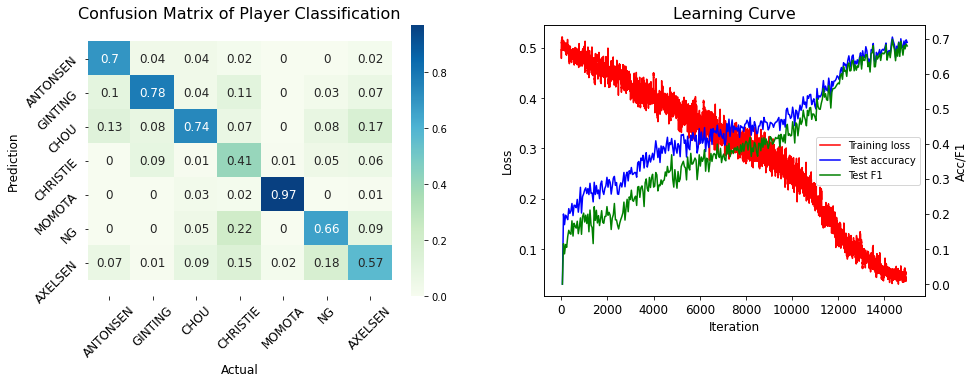

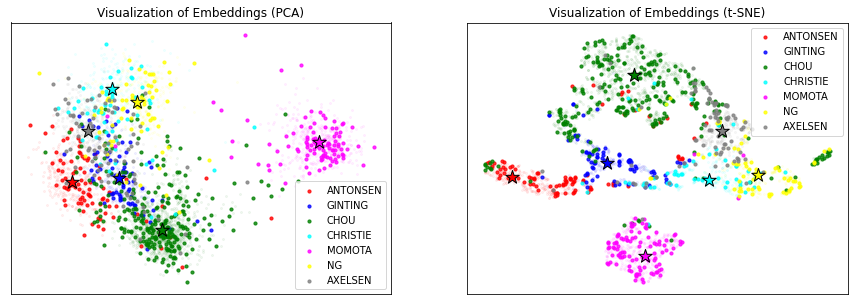

 70%|██████▉   | 349/500 [6:51:44<2:51:47, 68.26s/it]

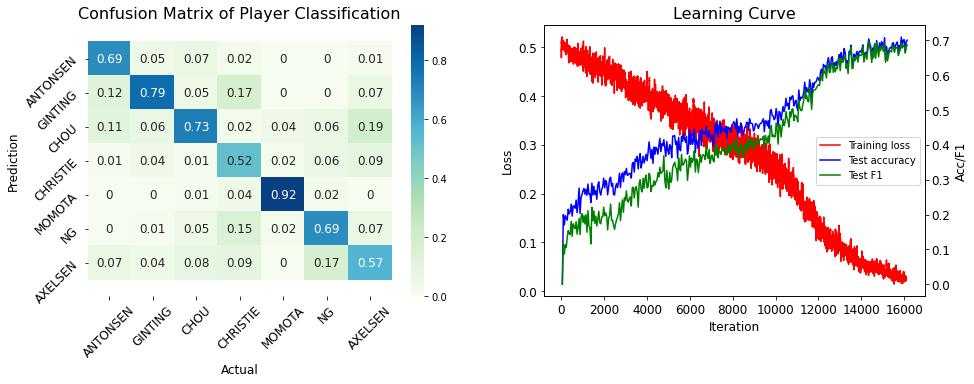

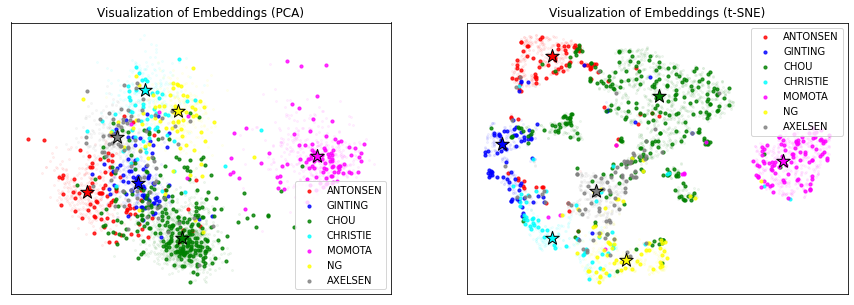

 75%|███████▍  | 374/500 [7:21:03<2:23:49, 68.49s/it]

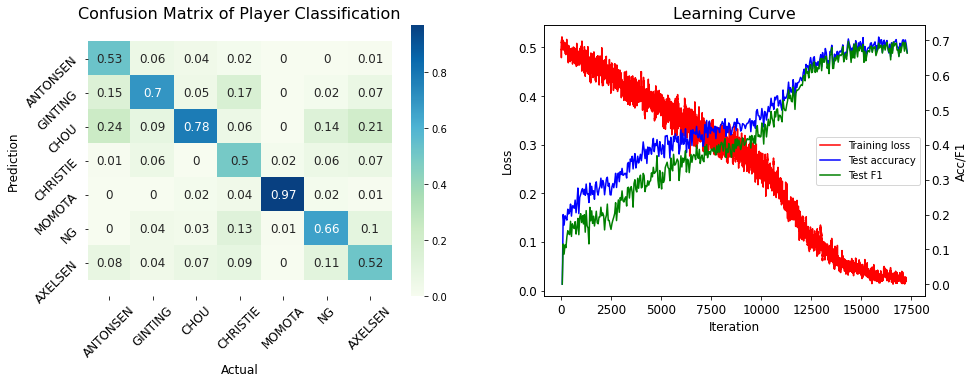

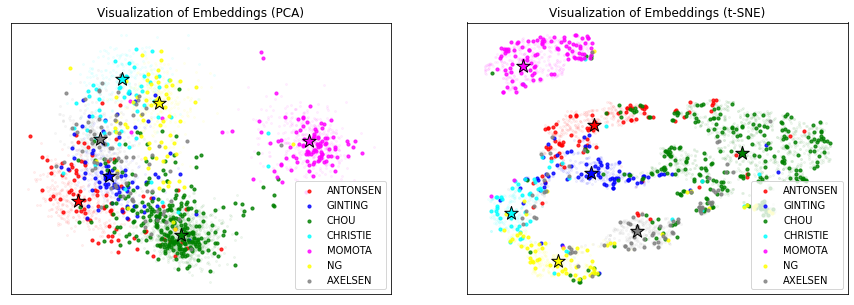

 80%|███████▉  | 399/500 [7:50:22<1:55:19, 68.51s/it]

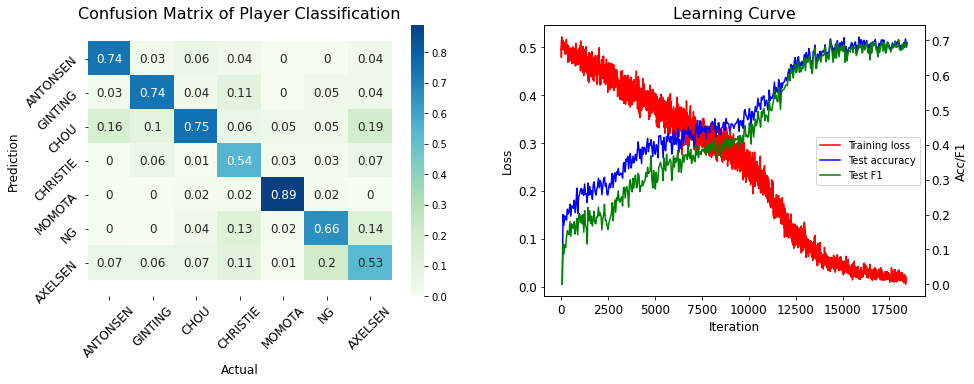

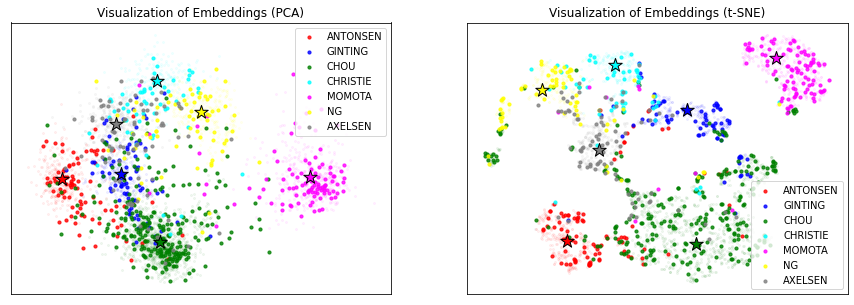

 85%|████████▍ | 424/500 [8:19:36<1:26:32, 68.33s/it]

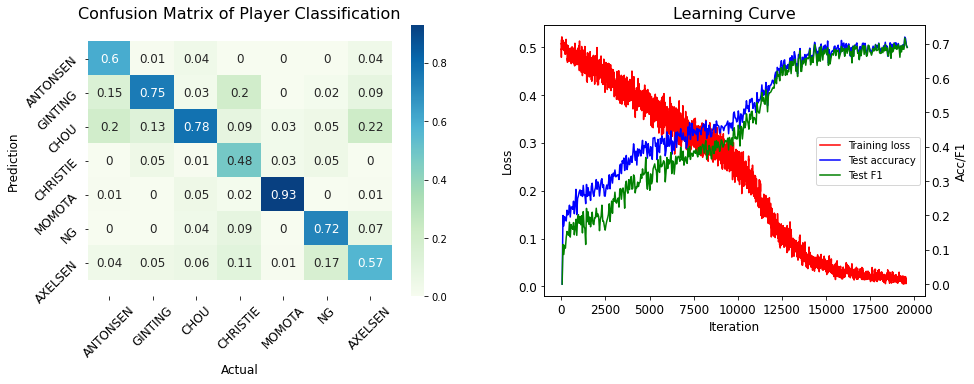

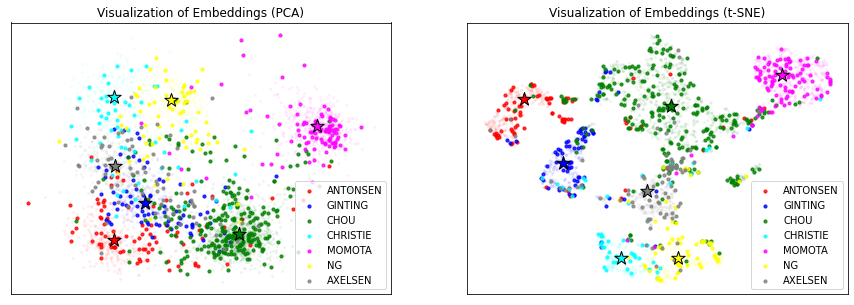

 90%|████████▉ | 449/500 [8:48:51<58:22, 68.67s/it]  

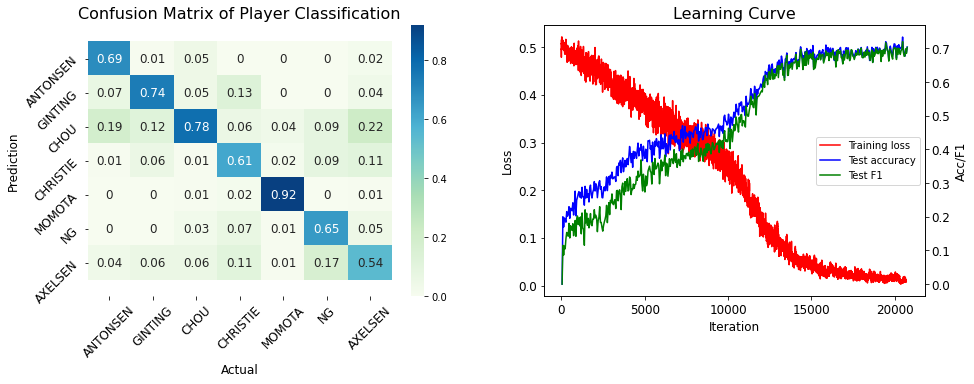

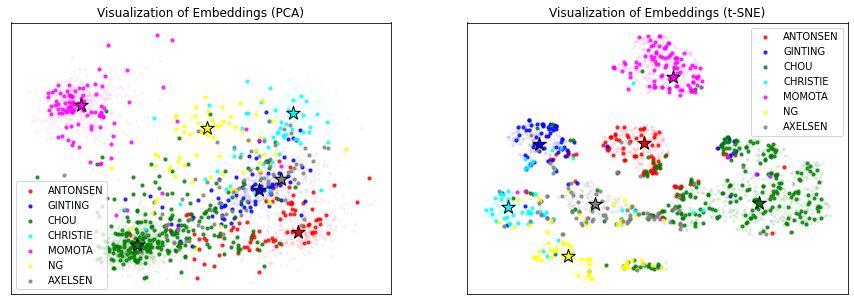

 95%|█████████▍| 474/500 [9:18:03<29:35, 68.30s/it]  

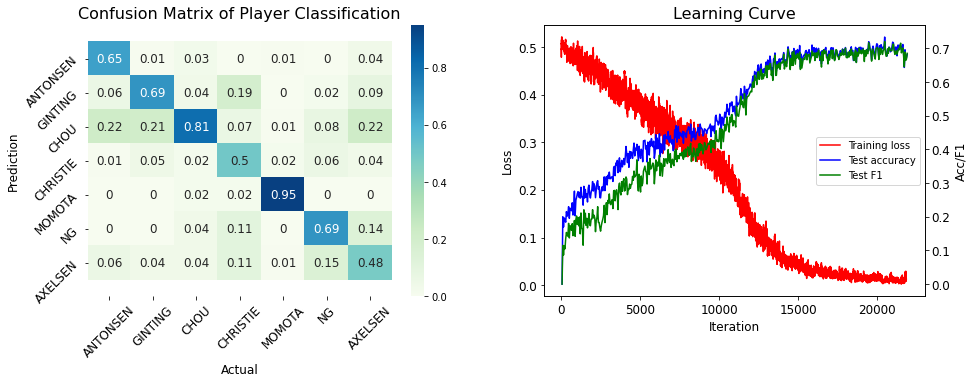

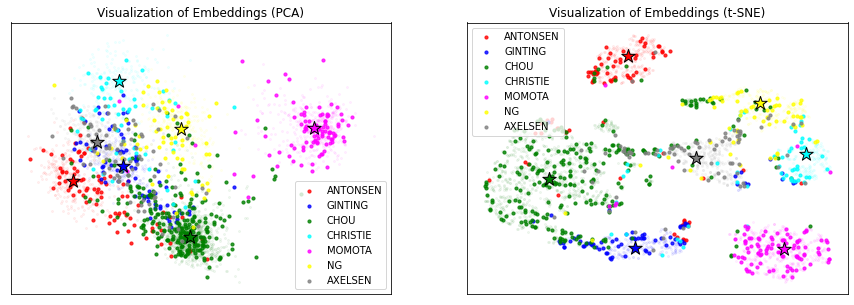

100%|█████████▉| 499/500 [9:47:22<01:08, 68.38s/it]

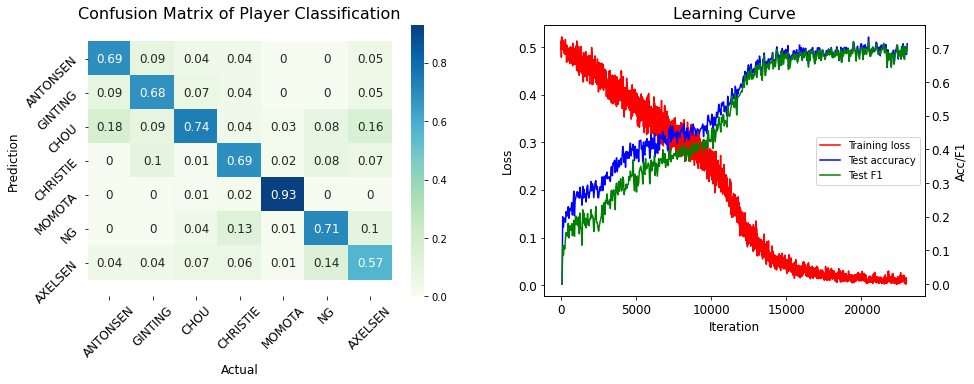

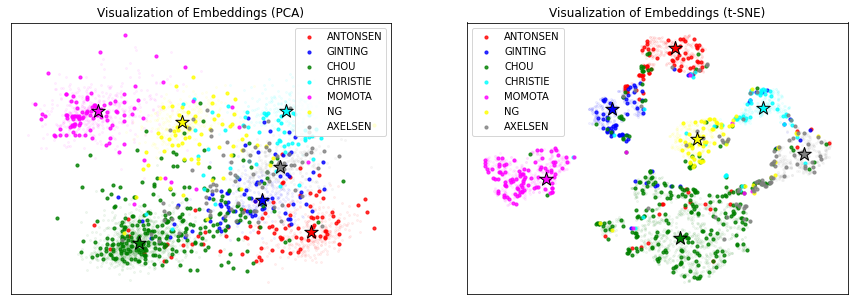

100%|██████████| 500/500 [9:49:15<00:00, 70.71s/it]


In [32]:
out = Output()
display.display(out)

losses = []
accs = [0]
f1s = [0]
gc.collect()
# pbar = tqdm(total = EPOCHS*len(trainloader))
# pbar.set_description("Training for %d epochs."%EPOCHS)
for epoch in tqdm(range(EPOCHS)):
    net.train()
    for idx, (anchor, positive, negative, anchor_len, positive_len, negative_len, anchor_label) in enumerate(trainloader):
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
        anchor_label = anchor_label.cuda()
        optimizer.zero_grad()

        anchor_embedding, acnhor_logits = net(anchor, anchor_len)
        positive_embedding, _ = net(positive, positive_len)
        negative_embedding, _ = net(negative, negative_len)
        
        #anchor_output = torch.max(torch.cdist(anchor_embedding, class_embedding, p=2), dim=-1, keepdim=True)[0].repeat(1, num_classes) - torch.cdist(anchor_embedding, class_embedding, p=2) + 1e-4
        #anchor_output = softmax(anchor_output)

#         t_loss = margin_loss(anchor_embedding, positive_embedding, negative_embedding)        
        t_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
#         c_loss = ce_loss(acnhor_logits, anchor_label.long())

        loss = t_loss #+ c_loss
        
        loss.backward()
        losses.append((loss).item())
#         pbar.set_postfix({'epoch': epoch, 'loss': sum(losses[-min(len(losses), len(trainloader)):])/min(len(losses), len(trainloader)), 'acc': accs[-1], 'f1': f1s[-1]})
        optimizer.step()
#         pbar.update()

    if (epoch+1) % 25 == 0:
        train_embeddings, train_labels = generate_all_embedding(num_classes, hidden_dim, net, pc_loader)
        # update dist mtrx
        trainloader.dataset.update_distance(train_embeddings)
        test_embeddings, test_labels = generate_all_embedding(num_classes, hidden_dim, net, testloader)
        class_embedding = generate_class_embedding(num_classes, hidden_dim, net, pc_loader)
        with out:
            #clear_output(wait=True)
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            acc, f1 = validation(net, class_embedding, testloader, num_classes, epoch, axes[0], conf=True)
            accs.append(acc)
            f1s.append(f1)
            plots(losses, accs, f1s, 10, axes[1])
            plt.show()
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[0], 'pca')
            tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[1], 'tsne')
            plt.show()

    else:
        train_embeddings, train_labels = generate_all_embedding(num_classes, hidden_dim, net, pc_loader)
        # update dist mtrx every epoch
        trainloader.dataset.update_distance(train_embeddings)
        class_embedding = generate_class_embedding(num_classes, hidden_dim, net, pc_loader)
        acc, f1 = validation(net, class_embedding, testloader, num_classes, epoch, ax=None)
        accs.append(acc)
        f1s.append(f1)

In [33]:
torch.save(net.state_dict(), 'distance_weighted_sampling_margin_loss.pt')

In [34]:
def class_distance_viz(class_embedding):
    class_dist = torch.cdist(class_embedding, class_embedding, p=2).cpu().numpy()#/class_embedding.shape[1]
    fig, ax = plt.subplots(figsize=(7, 5))
    df = pd.DataFrame(class_dist, [cat2player(i) for i in range(num_classes)], [cat2player(i) for i in range(num_classes)])
    
    sn.heatmap(df, annot=True, annot_kws={"size": 10}, cmap='GnBu', fmt='.2f', ax=ax, square=True)
    b, t = ax.get_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    ax.set_title("Distance of Embedding between Players")
    ax.set_ylim(b, t) # update the ylim(bottom, top) values
    ax.xaxis.set_tick_params(rotation=90)
    ax.yaxis.set_tick_params(rotation=0)
    ax.set_xlabel('Player')
    ax.set_ylabel('Player')
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.title.set_fontsize(16)

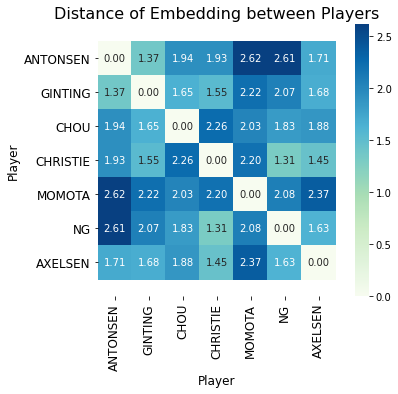

In [35]:
class_distance_viz(class_embedding)

In [36]:
labels = []
preds = []
lengths = []
for idx, (seq, seq_length, label) in enumerate(testloader):
    # seq: [batch x padded length x feat dim]
    # label [batch x 2]
    sigmoid = nn.Sigmoid()
    seq, label = torch.Tensor(seq).cuda(), torch.Tensor(label).long().cuda()
    output,_ = net(seq, seq_length)

    pred = torch.argmin(torch.cdist(output, class_embedding, p=2), dim=-1)
    #pred = torch.argmax(output, dim=-1)

    labels.append(label.cpu().item())
    preds.append(pred.detach().cpu().item())
    lengths.append(seq_length[0])   
#acc, prec, rec, f1, ACC = metrices(preds, labels, num_classes)


In [37]:
len(labels), len(preds), len(lengths)

(739, 739, 739)

In [38]:
l, p, n = np.array(labels), np.array(preds), np.array(lengths)

In [39]:
accs = []
f1s = []
wind = 1
#for i in range(np.ceil(n.max()/wind).astype(int)):
for i in range(3, 20):
    subset = np.where((n >= i*wind) & (n < (i+1)*wind))
    acc, prec, rec, f1, ACC = metrices(p[subset], l[subset], num_classes)
    accs.append(rec)
    f1s.append(f1)

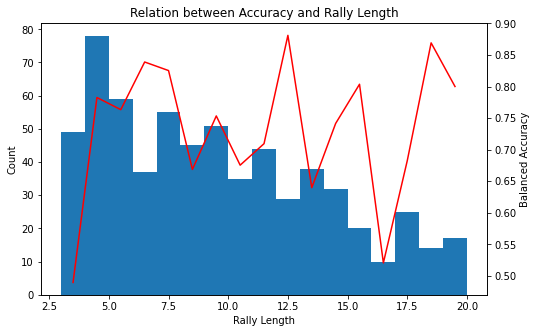

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(n, bins=17, range=(3, 20))

ax2 = ax.twinx()
#ax2.plot([i*wind + wind/2 for i in range(np.ceil(n.max()/wind).astype(int))], accs, 'r')
ax2.plot([i*wind + wind/2 for i in range(3, 20)], accs, 'r')

plt.title("Relation between Accuracy and Rally Length")
ax.set_xlabel('Rally Length')
ax.set_ylabel('Count')
ax2.set_ylabel('Balanced Accuracy')
plt.show()

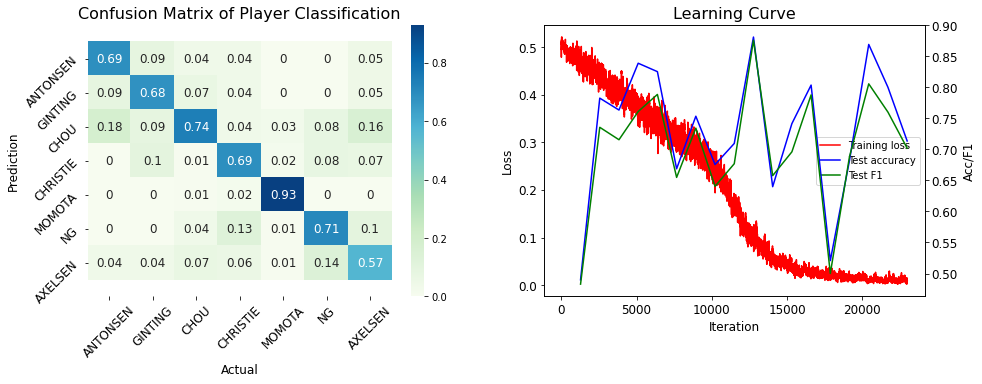

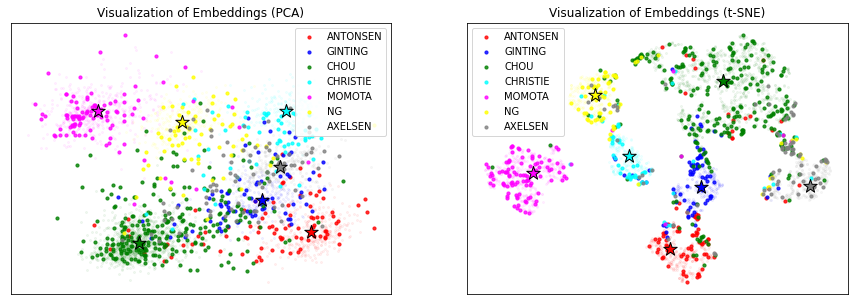

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc, f1 = validation(net, class_embedding, testloader, num_classes, epoch, axes[0], conf=True)
accs.append(acc)
f1s.append(f1)
plots(losses, accs, f1s, 10, axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[0], 'pca')
tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[1], 'tsne')
plt.show()

In [30]:
from collections import Counter
c = Counter()
for i in range(len(pc_dataset)):
    c[int(pc_dataset[i][1])] += 1
print(c)

Counter({2: 1079, 4: 450, 6: 316, 0: 308, 1: 275, 5: 268, 3: 215})
